In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.svm import OneClassSVM
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, mean_squared_error
from sklearn.decomposition import PCA, TruncatedSVD, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import ConvergenceWarning
import itertools
import pickle
import logging
import warnings

In [2]:
df = pd.read_csv("../data/run-over-dataset.csv")
print(df.shape)

columns_to_drop = ['VERBALE', 'DATA', 'Tot Testa', 'Tot Torace', 'Tot Addome', 'Tot Scheletro',
                    'Totale', 'Tot Volta cranica', 'Tot Base cranica', 
                    'Tot Neuroc.', 'Tot Splancnoc.', 'Tot Testa',
                    'Tot Tratto toracico', 'Tot Tratto lombare', 'Tot Rachide',
                    ' Totale coste', 'Sterno in toto', 'Tot Bacino', 'I costa dx', 'II costa dx',
                    'III costa dx', 'IV costa dx', 'V costa dx', 'VI costa dx', 'VII costa dx', 
                    'VIII costa dx', 'IX costa dx', 'X costa dx', 'XI costa dx', 'XII costa dx',
                    'I costa sx', 'II costa sx', 'III costa sx', 'IV costa sx', 'V costa sx', 
                    'VI costa sx', 'VII costa sx', 'VIII costa sx', 'IX costa sx', 
                    'X costa sx', 'XI costa sx', 'XII costa sx']

X = df.drop(columns=columns_to_drop)
print(X.shape)

X['ALTEZZA'] = [int(float(h.replace(',', '.'))*100) for h in X['ALTEZZA']]
X['PESO'] = [int(float(str(h).replace(',', '.'))) for h in X['PESO']]
X['BMI'] = [float(str(h).replace(',', '.')) for h in X['BMI']]

num_unique_values = X.nunique()
constant_columns = num_unique_values[num_unique_values == 1].index.tolist()

X = X.drop(columns=constant_columns)
X = X.T.drop_duplicates().T
print(X.shape)

(130, 367)
(130, 326)
(130, 274)


In [3]:
random_seed = 3355825

In [5]:
def plot_mse_neural(X, layer_sizes, n_iter):
    X_train, X_test = train_test_split(X, test_size=0.7, random_state=random_seed)

    scaler = RobustScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    fig, axs = plt.subplots(4, 2, figsize=(20, 15))

    for idx, (layer_size) in enumerate(layer_sizes):
        hidden_layer_sizes = (layer_size,) 
        mse_values = []
        
        for n_max_iter in range(1, n_iter+1):
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=ConvergenceWarning)

                mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, max_iter=n_max_iter, random_state=random_seed, solver='sgd', warm_start=True)
                mlp.fit(X_train, X_train)

                X_pred = mlp.predict(X_train)

                mse = mean_squared_error(X_train, X_pred)
                mse_values.append(mse)

        axs[int(idx / 2), idx % 2].plot(range(1, n_iter+1), mse_values, marker='o')
        axs[int(idx / 2), idx % 2].set_title('MSE vs. Number of Iterations (' + str(layer_size) + ' size)')
        axs[int(idx / 2), idx % 2].set_xlabel('Number of Iterations')
        axs[int(idx / 2), idx % 2].set_ylabel('Mean Squared Error')

    plt.tight_layout()     
    plt.show()

In [4]:
class EncoderMLP:
    def __init__(self, hidden_layer_size=60, max_iter=50, random_state=None, solver='sgd'):
        self.hidden_layer_size = hidden_layer_size
        self.max_iter = max_iter
        self.random_state = random_state
        self.solver = solver
        self.model = MLPRegressor(hidden_layer_sizes=(self.hidden_layer_size,),
                                  max_iter=self.max_iter,
                                  random_state=self.random_state,
                                  solver=self.solver)
        
        self.activation_map = {
            'identity': lambda x: x,
            'logistic': lambda x: 1 / (1 + np.exp(-x)),
            'tanh': np.tanh,
            'relu': lambda x: np.maximum(0, x)
        }

    def fit(self, X):
        """Addestra l'MLPRegressor con i dati forniti."""
        self.model.fit(X, X)

    def transform(self, X):
        """Ottiene le feature ridotte usando l'output del layer nascosto."""
        hidden_layer_output = np.dot(X, self.model.coefs_[0]) + self.model.intercepts_[0]
        activation_func = self.activation_map[self.model.activation]
        hidden_layer_output = activation_func(hidden_layer_output)
        return hidden_layer_output

    def fit_transform(self, X):
        """Addestra il modello e trasforma i dati in una sola chiamata."""
        self.fit(X)
        return self.transform(X)


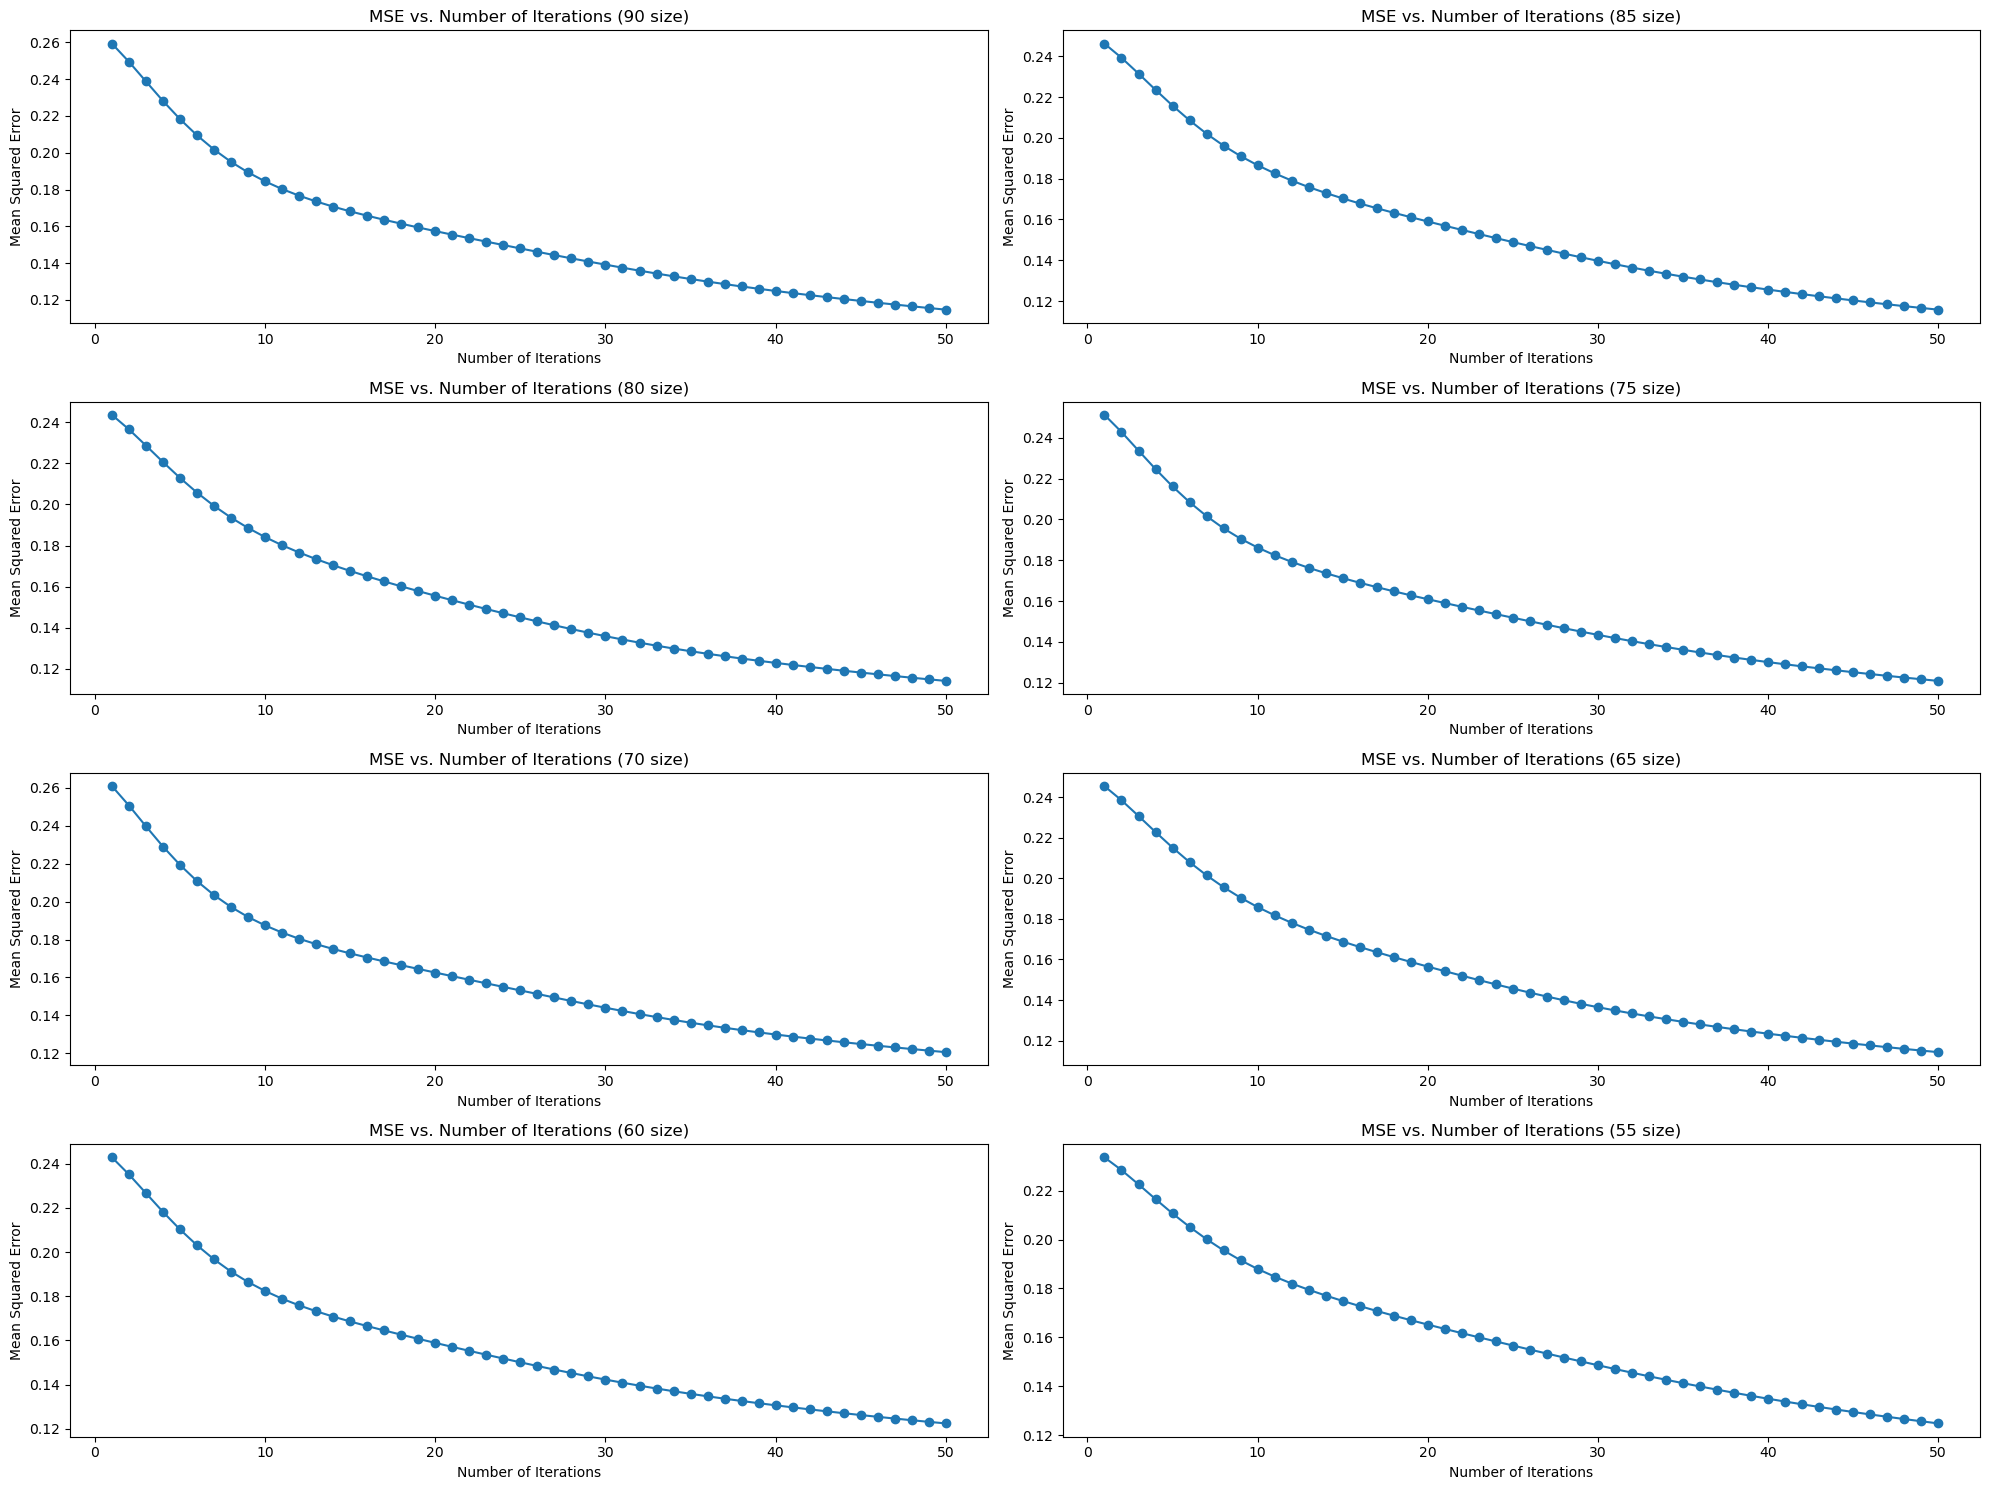

In [9]:
plot_mse_neural(X, np.arange(90, 54, -5), n_iter=50)

In [30]:
def plot_mse_neural_on_other_class(X, layer_sizes, n_iter, positive_class=0):
    y = X['Mezzo'].values
    y = np.array([0. if x == positive_class else 1. for x in y], dtype=float)
    
    X = X.drop(columns='Mezzo').values
    outer_cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=random_seed)
    
    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
        for trainval_idx, valid_idx in inner_cv.split(X_train, y_train):
            X_trainval, X_valid = X_train[trainval_idx], X_train[valid_idx]
            y_trainval, y_valid = y_train[trainval_idx], y_train[valid_idx]

            scaler = MinMaxScaler()
            X_trainval_scaled = scaler.fit_transform(X_trainval)
            X_valid_scaled = scaler.transform(X_valid)

            idxs_neg = np.where(y_trainval == 1)[0]
                
            X_trainval_reduced = np.delete(X_trainval_scaled, idxs_neg, axis=0)
            y_trainval = np.delete(y_trainval, idxs_neg)

            fig, axs = plt.subplots(4, 2, figsize=(20, 15))

            for idx, (layer_size) in enumerate(layer_sizes):
                hidden_layer_sizes = (layer_size,) 
                mse_values = []
                
                for n_max_iter in range(1, n_iter+1):
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore", category=ConvergenceWarning)

                        mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, max_iter=n_max_iter, random_state=random_seed, solver='sgd', warm_start=True)
                        mlp.fit(X_trainval_reduced, X_trainval_reduced)

                        X_pred = mlp.predict(X_valid_scaled)

                        mse = mean_squared_error(X_valid_scaled, X_pred)
                        mse_values.append(mse)

                axs[int(idx / 2), idx % 2].plot(range(1, n_iter+1), mse_values, marker='o')
                axs[int(idx / 2), idx % 2].set_title('MSE vs. Number of Iterations (' + str(layer_size) + ' size)')
                axs[int(idx / 2), idx % 2].set_xlabel('Number of Iterations')
                axs[int(idx / 2), idx % 2].set_ylabel('Mean Squared Error')
            
            break        
        break

    plt.tight_layout()     
    plt.show()

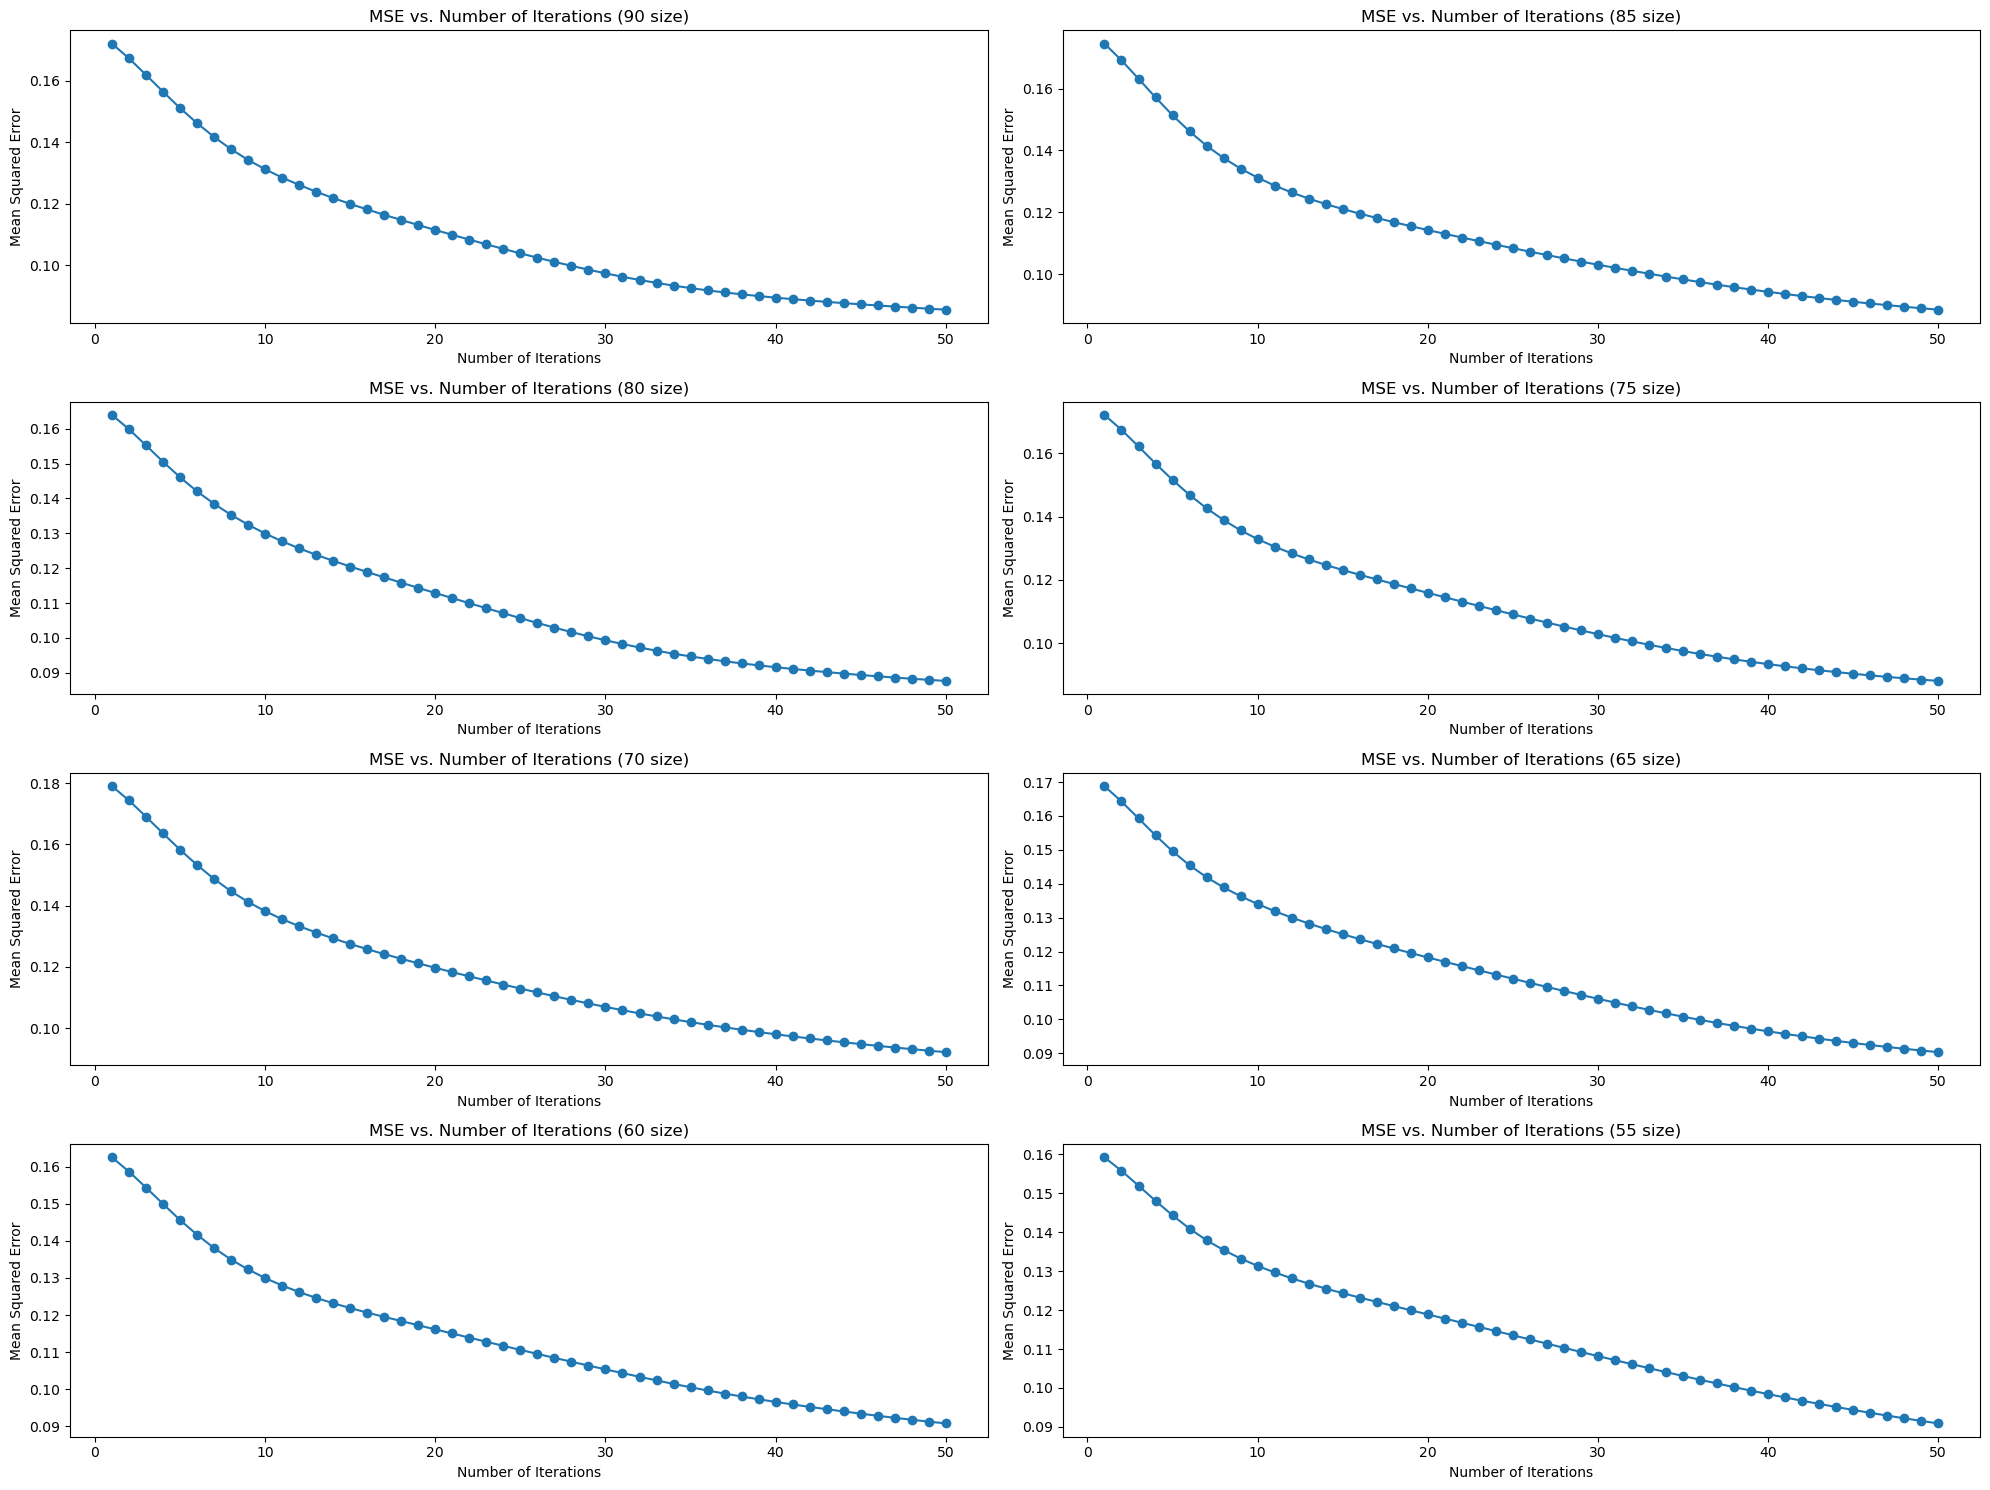

In [31]:
plot_mse_neural_on_other_class(X, np.arange(90, 54, -5), n_iter=50)

In [32]:
def plot_mse_neural_on_2_classes(X, layer_sizes, n_iter, positive_class=0):
    y = X['Mezzo'].values
    y = np.array([0. if x == positive_class else 1. for x in y], dtype=float)
    
    X = X.drop(columns='Mezzo').values
    outer_cv = StratifiedKFold(n_splits=7, shuffle=True, random_state=random_seed)
    
    for train_idx, test_idx in outer_cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)
        for trainval_idx, valid_idx in inner_cv.split(X_train, y_train):
            X_trainval, X_valid = X_train[trainval_idx], X_train[valid_idx]
            y_trainval, y_valid = y_train[trainval_idx], y_train[valid_idx]

            scaler = MinMaxScaler()
            X_trainval_scaled = scaler.fit_transform(X_trainval)
            X_valid_scaled = scaler.transform(X_valid)

            fig, axs = plt.subplots(4, 2, figsize=(20, 15))

            for idx, (layer_size) in enumerate(layer_sizes):
                hidden_layer_sizes = (layer_size,) 
                mse_values = []
                
                for n_max_iter in range(1, n_iter+1):
                    with warnings.catch_warnings():
                        warnings.filterwarnings("ignore", category=ConvergenceWarning)

                        mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, max_iter=n_max_iter, random_state=random_seed, solver='sgd', warm_start=True)
                        mlp.fit(X_trainval_scaled, X_trainval_scaled)

                        X_pred = mlp.predict(X_valid_scaled)

                        mse = mean_squared_error(X_valid_scaled, X_pred)
                        mse_values.append(mse)

                axs[int(idx / 2), idx % 2].plot(range(1, n_iter+1), mse_values, marker='o')
                axs[int(idx / 2), idx % 2].set_title('MSE vs. Number of Iterations (' + str(layer_size) + ' size)')
                axs[int(idx / 2), idx % 2].set_xlabel('Number of Iterations')
                axs[int(idx / 2), idx % 2].set_ylabel('Mean Squared Error')
            
            break        
        break

    plt.tight_layout()     
    plt.show()

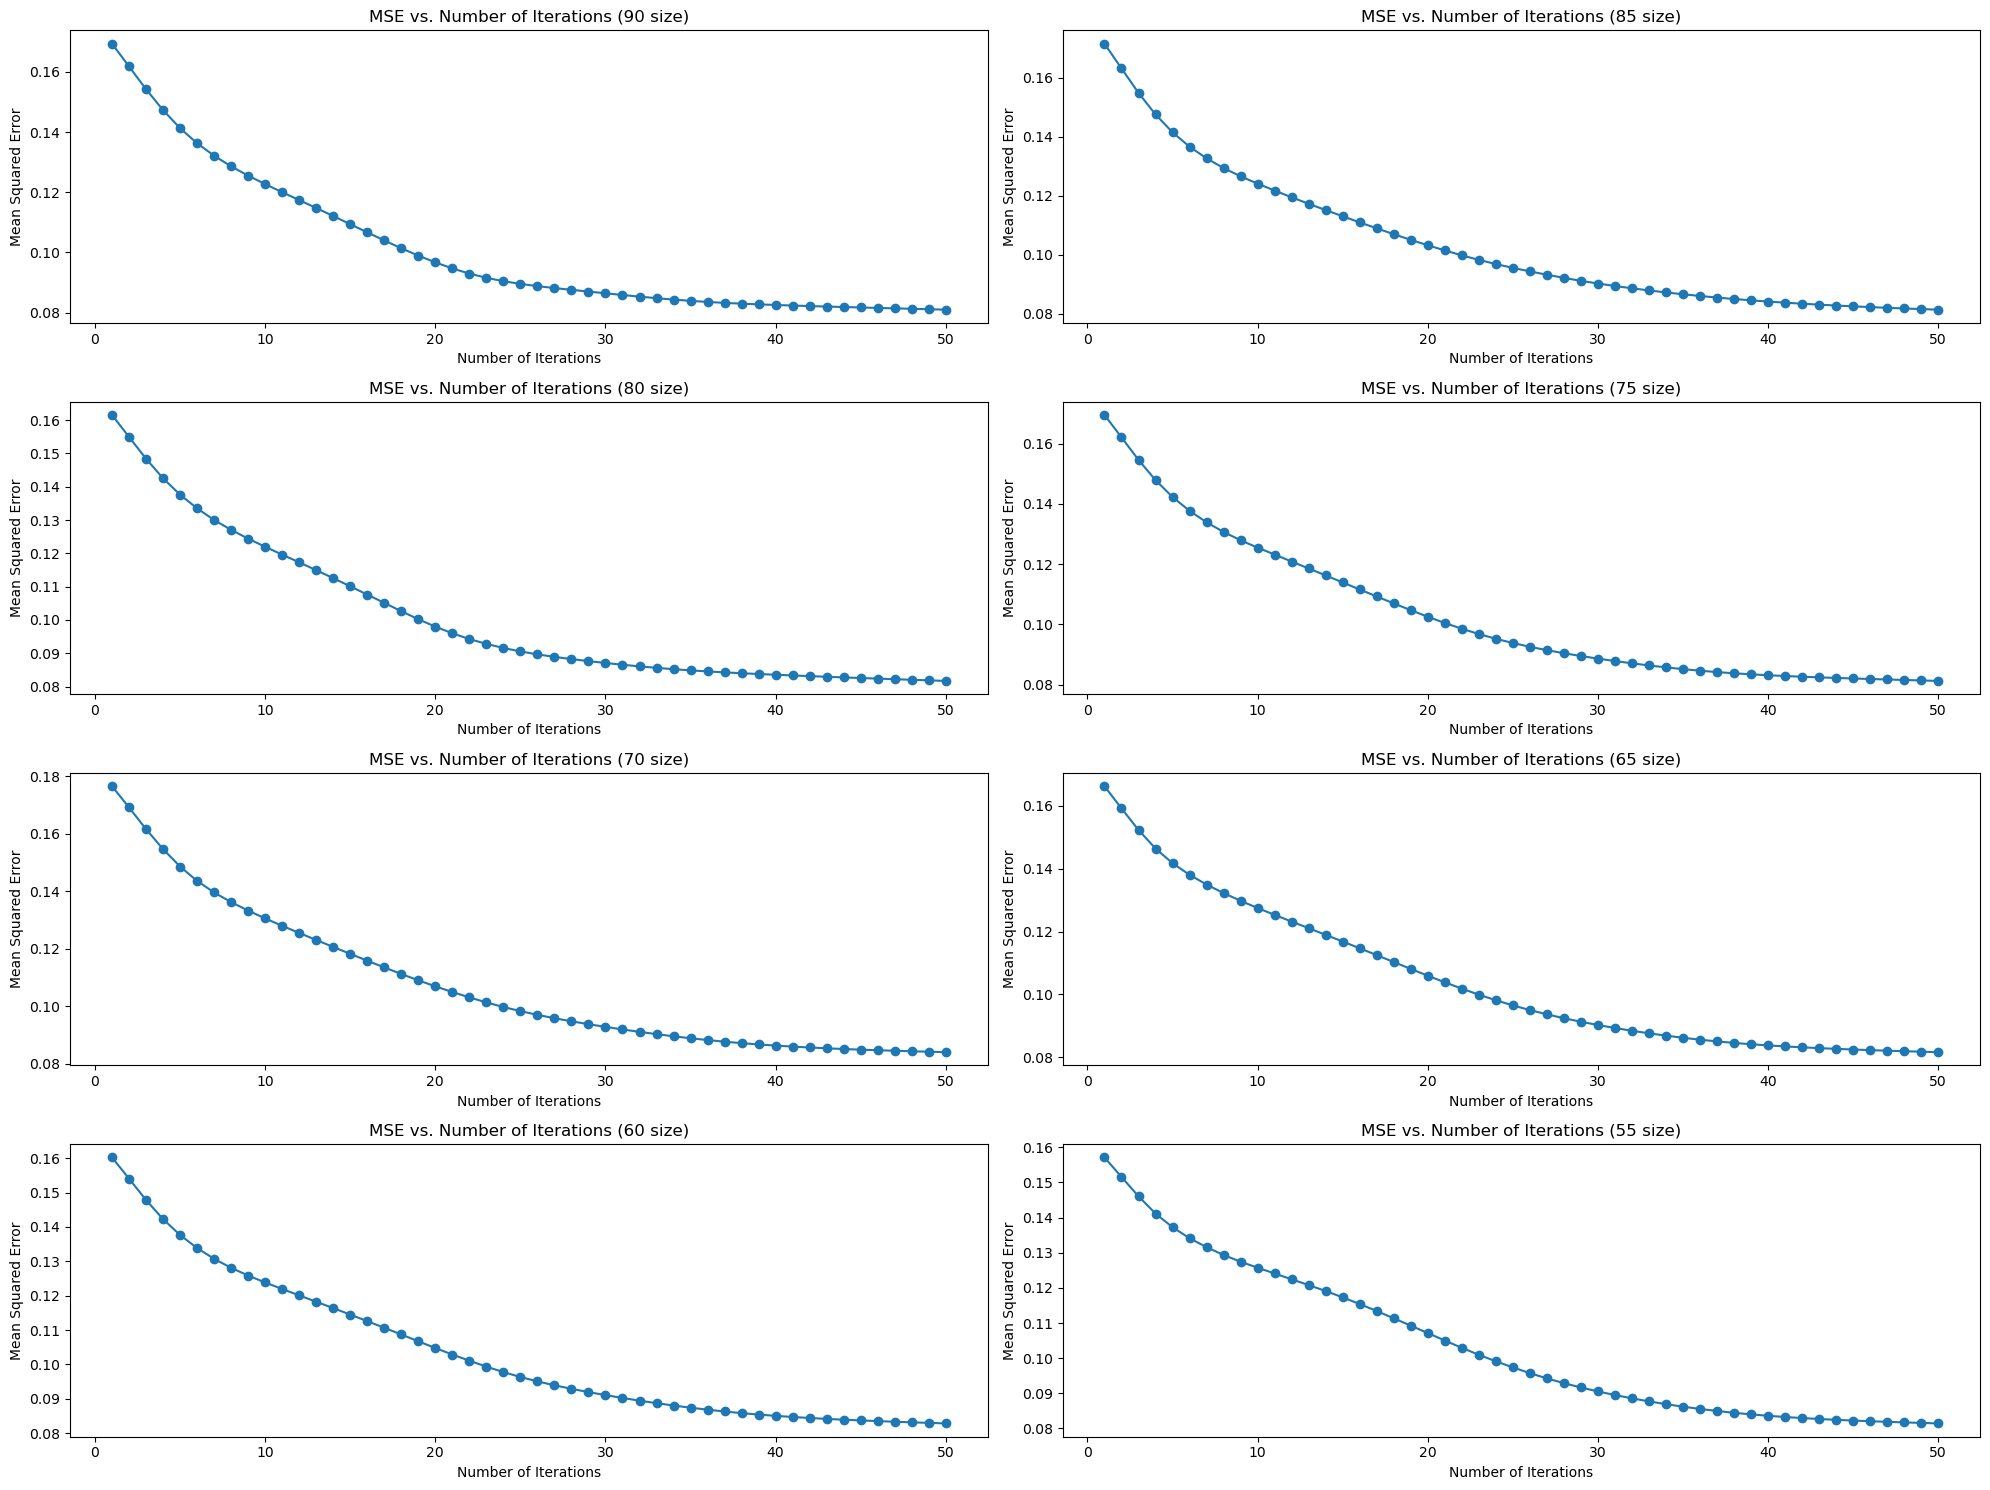

In [33]:
plot_mse_neural_on_2_classes(X, np.arange(90, 54, -5), n_iter=50)

L'MSE delle trasformazioni effettuate con MLPRegressor con il fit fatto solo sulla classe positiva è simile a quello fattto con il fit effettuato su entrambe le classi. Con il fit fatto su entrambe le classi è leggermente migliore.

In [9]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

file_handler = logging.FileHandler('../logs/svm_neural_nested_cv.log')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger()

logger.handlers = []
logger.addHandler(file_handler)

In [10]:
def nested_cv_extended(X, random_seed, decomposition=EncoderMLP, n_outer_folds=7, n_inner_folds=5, n_components=65, mod_selection_score=accuracy_score, positive_class=0):
    kernels = ['linear', 'rbf']
    gammas = np.logspace(-3, 3, 7)
    nus = np.linspace(0.01, 0.50, 25) 
    scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
    
    best_params = {'kernel': '', 'gamma': 0, 'nu': 0, 'components': 0, 'scaler': ''}
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    best_overall_accuracy = 0
    best_overall_params = {'kernel': '', 'gamma': 0, 'nu': 0, 'components': 0, 'scaler': ''}

    y = X['Mezzo'].values
    y = np.array([0. if x == positive_class else 1. for x in y], dtype=float)
    
    X = X.drop(columns='Mezzo').values

    outer_cv = StratifiedKFold(n_splits=n_outer_folds, shuffle=True, random_state=random_seed)
        
    for outer_cv_number, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        inner_cv = StratifiedKFold(n_splits=n_inner_folds, shuffle=True, random_state=random_seed)

        best_score = 0
        best_scaler = None
        best_encoder = None
        for inner_cv_number, (trainval_idx, valid_idx) in enumerate(inner_cv.split(X_train, y_train)):
            for kernel in kernels:
                param_combinations = itertools.product([kernel], gammas, nus, scalers)
                
                if kernel == 'linear':
                    param_combinations = itertools.product(['linear'], [0.001], nus, scalers)
                elif kernel == 'rbf':
                    param_combinations = itertools.product(['rbf'], gammas, nus, scalers)

                for params in param_combinations:
                    scaler = params[3]
                    X_trainval, X_valid = X_train[trainval_idx], X_train[valid_idx]
                    y_trainval, y_valid = y_train[trainval_idx], y_train[valid_idx]

                    X_trainval_scaled = scaler.fit_transform(X_trainval)
                    X_valid_scaled = scaler.transform(X_valid)

                    encoder = decomposition(hidden_layer_size=n_components, max_iter=50, random_state=random_seed, solver='sgd')
                    encoder.fit(X_train)
                    
                    X_trainval_reduced = encoder.transform(X_trainval_scaled)
                    X_valid_reduced = encoder.transform(X_valid_scaled)
                        
                    idxs_neg = np.where(y_trainval == 1)[0]
                
                    X_trainval_reduced = np.delete(X_trainval_reduced, idxs_neg, axis=0)
                    y_trainval = np.delete(y_trainval, idxs_neg)

                    clf = OneClassSVM(kernel=params[0], gamma=params[1], nu=params[2])
                        
                    clf.fit(X_trainval_reduced)
                        
                    pred_values = clf.predict(X_valid_reduced)
                    true_values = [1 if y == 0 else -1 for y in y_valid]
                        
                    score = mod_selection_score(true_values, pred_values)
                    curr_params = {
                            'kernel': params[0],
                            'gamma': params[1],
                            'nu': params[2],
                            'components': n_components,
                            'scaler': params[3]
                    }

                    logging.info(f"inner cv number: {inner_cv_number}, {mod_selection_score.__name__}: {score}, with params: {curr_params}")
                            
                    if score > best_score:
                        best_score = score
                        best_encoder = encoder
                        best_scaler = scaler
                        best_params = curr_params

        idxs_neg = np.where(y_train == 1)[0]
        X_train = np.delete(X_train, idxs_neg, axis=0)
        y_train = np.delete(y_train, idxs_neg)

        X_train_scaled = best_scaler.fit_transform(X_train)
        X_test_scaled = best_scaler.transform(X_test)

        X_train_reduced = best_encoder.transform(X_train_scaled)
        X_test_reduced = best_encoder.transform(X_test_scaled)

        clf = OneClassSVM(kernel=best_params['kernel'], gamma=best_params['gamma'], nu=best_params['nu'])
        clf.fit(X_train_reduced)

        pred_values = clf.predict(X_test_reduced)
        true_values = [1 if y == 0 else -1 for y in y_test]

        accuracy = accuracy_score(true_values, pred_values)
        precision = precision_score(true_values, pred_values, zero_division=0.0)
        recall = recall_score(true_values, pred_values)
        f1 = f1_score(true_values, pred_values)

        if accuracy > best_overall_accuracy:
            best_overall_accuracy = accuracy
            best_overall_params = best_params

        logging.info(f"outer cv number: {outer_cv_number}, accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {f1} with params: {best_params}")

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

    return {
        'algorythm': 'OneClassSVM',
        'best kernel': best_overall_params['kernel'],
        'best gamma': best_overall_params['gamma'],
        'best nu': best_overall_params['nu'],
        'n_components': best_overall_params['components'],
        'best scaler': best_overall_params['scaler'],
        'score used for model selection': mod_selection_score.__name__,
        'method used for model selection': 'nested cv',
        'accuracy mean': np.mean(accuracy_scores) * 100,
        'accuracy std': np.std(accuracy_scores) * 100,
        'precision mean': np.mean(precision_scores) * 100,
        'precision std': np.std(precision_scores) * 100,
        'recall mean': np.mean(recall_scores) * 100,
        'recall std': np.std(recall_scores) * 100,
        'f1 mean': np.mean(f1_scores) * 100,
        'f1 std': np.std(f1_scores) * 100,
        'best overall accuracy': best_overall_accuracy * 100,
        'class': positive_class
    }

In [8]:
results = nested_cv_extended(X, random_seed, n_components=90, mod_selection_score=accuracy_score)
scores_df = pd.DataFrame(results, index=[0])
scores_df

,algorythm,best kernel,best gamma,best nu,n_components,best scaler,score used for model selection,method used for model selection,accuracy mean,accuracy std,precision mean,precision std,recall mean,recall std,f1 mean,f1 std,best overall accuracy,class
0,OneClassSVM,rbf,0.001,0.255,90,MinMaxScaler(),accuracy_score,nested cv,55.388471,16.087458,54.875283,25.564176,44.285714,24.989794,48.359133,24.71143,88.888889,0


In [5]:
def add_record(df, record):
    new_record = pd.DataFrame(record, index=[0])
    df = pd.concat([df, new_record], ignore_index=True)
    return df  

In [10]:
for n_comp in range (85, 49, -5):
    scores_df = add_record(scores_df, nested_cv_extended(X, random_seed, n_components=n_comp, mod_selection_score=accuracy_score))

scores_df

,algorythm,best kernel,best gamma,best nu,n_components,best scaler,score used for model selection,method used for model selection,accuracy mean,accuracy std,precision mean,precision std,recall mean,recall std,f1 mean,f1 std,best overall accuracy,class
0,OneClassSVM,rbf,0.001,0.255000,90,MinMaxScaler(),accuracy_score,nested cv,55.388471,16.087458,54.875283,25.564176,44.285714,24.989794,48.359133,24.711430,88.888889,0
1,OneClassSVM,rbf,0.100,0.295833,85,MinMaxScaler(),accuracy_score,nested cv,60.025063,9.257930,66.545558,13.034036,57.142857,19.794866,59.511051,10.893912,68.421053,0
2,OneClassSVM,rbf,0.001,0.336667,80,MinMaxScaler(),accuracy_score,nested cv,63.784461,11.001114,74.115646,16.631018,51.428571,15.518258,59.700153,14.690772,73.684211,0
3,OneClassSVM,rbf,0.100,0.479583,75,MinMaxScaler(),accuracy_score,nested cv,58.521303,15.513562,63.809524,18.294641,54.285714,17.612611,57.726038,17.571019,83.333333,0
4,OneClassSVM,rbf,0.100,0.336667,70,MinMaxScaler(),accuracy_score,nested cv,53.968254,12.718321,57.777778,11.944692,55.714286,17.612611,55.699639,13.640542,77.777778,0
5,OneClassSVM,rbf,0.100,0.234583,65,MinMaxScaler(),accuracy_score,nested cv,63.951546,10.349289,64.032634,8.910834,70.000000,22.038927,65.552956,16.647977,83.333333,0
6,OneClassSVM,rbf,0.001,0.275417,60,MinMaxScaler(),accuracy_score,nested cv,63.074353,7.351950,64.049165,5.605483,71.428571,14.568627,66.984127,8.439716,72.222222,0
7,OneClassSVM,rbf,0.100,0.357083,55,MinMaxScaler(),accuracy_score,nested cv,57.184628,12.770073,58.388992,11.924388,55.714286,25.555063,55.654201,18.728437,83.333333,0
8,OneClassSVM,rbf,0.001,0.479583,50,MinMaxScaler(),accuracy_score,nested cv,66.875522,5.628103,78.356009,11.610786,57.142857,11.605769,64.487900,7.125725,73.684211,0


In [16]:
for n_comp in range (90, 49, -5):
    scores_df = add_record(scores_df, nested_cv_extended(X, random_seed, n_components=n_comp, mod_selection_score=f1_score))

scores_df

,algorythm,best kernel,best gamma,best nu,n_components,best scaler,score used for model selection,method used for model selection,accuracy mean,accuracy std,precision mean,precision std,recall mean,recall std,f1 mean,f1 std,best overall accuracy,class
0,OneClassSVM,rbf,0.001,0.255000,90,MinMaxScaler(),accuracy_score,nested cv,55.388471,16.087458,54.875283,25.564176,44.285714,24.989794,48.359133,24.711430,88.888889,0
1,OneClassSVM,rbf,0.100,0.295833,85,MinMaxScaler(),accuracy_score,nested cv,60.025063,9.257930,66.545558,13.034036,57.142857,19.794866,59.511051,10.893912,68.421053,0
2,OneClassSVM,rbf,0.001,0.336667,80,MinMaxScaler(),accuracy_score,nested cv,63.784461,11.001114,74.115646,16.631018,51.428571,15.518258,59.700153,14.690772,73.684211,0
3,OneClassSVM,rbf,0.100,0.479583,75,MinMaxScaler(),accuracy_score,nested cv,58.521303,15.513562,63.809524,18.294641,54.285714,17.612611,57.726038,17.571019,83.333333,0
4,OneClassSVM,rbf,0.100,0.336667,70,MinMaxScaler(),accuracy_score,nested cv,53.968254,12.718321,57.777778,11.944692,55.714286,17.612611,55.699639,13.640542,77.777778,0
5,OneClassSVM,rbf,0.100,0.234583,65,MinMaxScaler(),accuracy_score,nested cv,63.951546,10.349289,64.032634,8.910834,70.000000,22.038927,65.552956,16.647977,83.333333,0
6,OneClassSVM,rbf,0.001,0.275417,60,MinMaxScaler(),accuracy_score,nested cv,63.074353,7.351950,64.049165,5.605483,71.428571,14.568627,66.984127,8.439716,72.222222,0
7,OneClassSVM,rbf,0.100,0.357083,55,MinMaxScaler(),accuracy_score,nested cv,57.184628,12.770073,58.388992,11.924388,55.714286,25.555063,55.654201,18.728437,83.333333,0
8,OneClassSVM,rbf,0.001,0.479583,50,MinMaxScaler(),accuracy_score,nested cv,66.875522,5.628103,78.356009,11.610786,57.142857,11.605769,64.487900,7.125725,73.684211,0
9,OneClassSVM,rbf,0.001,0.255000,90,MinMaxScaler(),f1_score,nested cv,57.769424,13.703848,61.081458,12.343540,60.000000,21.380899,59.036517,15.687861,88.888889,0


In [13]:
for n_comp in range (45, 34, -5):
    scores_df = add_record(scores_df, nested_cv_extended(X, random_seed, n_components=n_comp, mod_selection_score=accuracy_score))

scores_df

,algorythm,best kernel,best gamma,best nu,n_components,best scaler,score used for model selection,method used for model selection,accuracy mean,accuracy std,precision mean,precision std,recall mean,recall std,f1 mean,f1 std,best overall accuracy,class
0,OneClassSVM,rbf,0.001,0.255000,90,MinMaxScaler(),accuracy_score,nested cv,55.388471,16.087458,54.875283,25.564176,44.285714,24.989794,48.359133,24.711430,88.888889,0
1,OneClassSVM,rbf,0.100,0.295833,85,MinMaxScaler(),accuracy_score,nested cv,60.025063,9.257930,66.545558,13.034036,57.142857,19.794866,59.511051,10.893912,68.421053,0
2,OneClassSVM,rbf,0.001,0.336667,80,MinMaxScaler(),accuracy_score,nested cv,63.784461,11.001114,74.115646,16.631018,51.428571,15.518258,59.700153,14.690772,73.684211,0
3,OneClassSVM,rbf,0.100,0.479583,75,MinMaxScaler(),accuracy_score,nested cv,58.521303,15.513562,63.809524,18.294641,54.285714,17.612611,57.726038,17.571019,83.333333,0
4,OneClassSVM,rbf,0.100,0.336667,70,MinMaxScaler(),accuracy_score,nested cv,53.968254,12.718321,57.777778,11.944692,55.714286,17.612611,55.699639,13.640542,77.777778,0
5,OneClassSVM,rbf,0.100,0.234583,65,MinMaxScaler(),accuracy_score,nested cv,63.951546,10.349289,64.032634,8.910834,70.000000,22.038927,65.552956,16.647977,83.333333,0
6,OneClassSVM,rbf,0.001,0.275417,60,MinMaxScaler(),accuracy_score,nested cv,63.074353,7.351950,64.049165,5.605483,71.428571,14.568627,66.984127,8.439716,72.222222,0
7,OneClassSVM,rbf,0.100,0.357083,55,MinMaxScaler(),accuracy_score,nested cv,57.184628,12.770073,58.388992,11.924388,55.714286,25.555063,55.654201,18.728437,83.333333,0
8,OneClassSVM,rbf,0.001,0.479583,50,MinMaxScaler(),accuracy_score,nested cv,66.875522,5.628103,78.356009,11.610786,57.142857,11.605769,64.487900,7.125725,73.684211,0
9,OneClassSVM,rbf,0.001,0.255000,90,MinMaxScaler(),f1_score,nested cv,57.769424,13.703848,61.081458,12.343540,60.000000,21.380899,59.036517,15.687861,88.888889,0


In [14]:
for n_comp in range (45, 34, -5):
    scores_df = add_record(scores_df, nested_cv_extended(X, random_seed, n_components=n_comp, mod_selection_score=f1_score))

scores_df

,algorythm,best kernel,best gamma,best nu,n_components,best scaler,score used for model selection,method used for model selection,accuracy mean,accuracy std,precision mean,precision std,recall mean,recall std,f1 mean,f1 std,best overall accuracy,class
0,OneClassSVM,rbf,0.001,0.255000,90,MinMaxScaler(),accuracy_score,nested cv,55.388471,16.087458,54.875283,25.564176,44.285714,24.989794,48.359133,24.711430,88.888889,0
1,OneClassSVM,rbf,0.100,0.295833,85,MinMaxScaler(),accuracy_score,nested cv,60.025063,9.257930,66.545558,13.034036,57.142857,19.794866,59.511051,10.893912,68.421053,0
2,OneClassSVM,rbf,0.001,0.336667,80,MinMaxScaler(),accuracy_score,nested cv,63.784461,11.001114,74.115646,16.631018,51.428571,15.518258,59.700153,14.690772,73.684211,0
3,OneClassSVM,rbf,0.100,0.479583,75,MinMaxScaler(),accuracy_score,nested cv,58.521303,15.513562,63.809524,18.294641,54.285714,17.612611,57.726038,17.571019,83.333333,0
4,OneClassSVM,rbf,0.100,0.336667,70,MinMaxScaler(),accuracy_score,nested cv,53.968254,12.718321,57.777778,11.944692,55.714286,17.612611,55.699639,13.640542,77.777778,0
5,OneClassSVM,rbf,0.100,0.234583,65,MinMaxScaler(),accuracy_score,nested cv,63.951546,10.349289,64.032634,8.910834,70.000000,22.038927,65.552956,16.647977,83.333333,0
6,OneClassSVM,rbf,0.001,0.275417,60,MinMaxScaler(),accuracy_score,nested cv,63.074353,7.351950,64.049165,5.605483,71.428571,14.568627,66.984127,8.439716,72.222222,0
7,OneClassSVM,rbf,0.100,0.357083,55,MinMaxScaler(),accuracy_score,nested cv,57.184628,12.770073,58.388992,11.924388,55.714286,25.555063,55.654201,18.728437,83.333333,0
8,OneClassSVM,rbf,0.001,0.479583,50,MinMaxScaler(),accuracy_score,nested cv,66.875522,5.628103,78.356009,11.610786,57.142857,11.605769,64.487900,7.125725,73.684211,0
9,OneClassSVM,rbf,0.001,0.255000,90,MinMaxScaler(),f1_score,nested cv,57.769424,13.703848,61.081458,12.343540,60.000000,21.380899,59.036517,15.687861,88.888889,0


In [18]:
def plot_error_bar(df, n_init, n_end, decomposition, score):
    df = df.iloc[n_init:n_end+1]
    n_comps = df['n_components']
    accuracy_mean = df['accuracy mean']
    accuracy_std = df['accuracy std']

    plt.figure(figsize=(10, 6))
    plt.errorbar(n_comps, accuracy_mean, yerr=accuracy_std, fmt='o', linestyle='--', color='b', ecolor='r', capsize=5)
    plt.title('Accuratezza con ' + decomposition + ' usando ' + score + " per la model selection")
    plt.xlabel('Numero di Componenti Principali')
    plt.ylabel('Accuratezza')
    plt.ylim(0,100)
    plt.show()

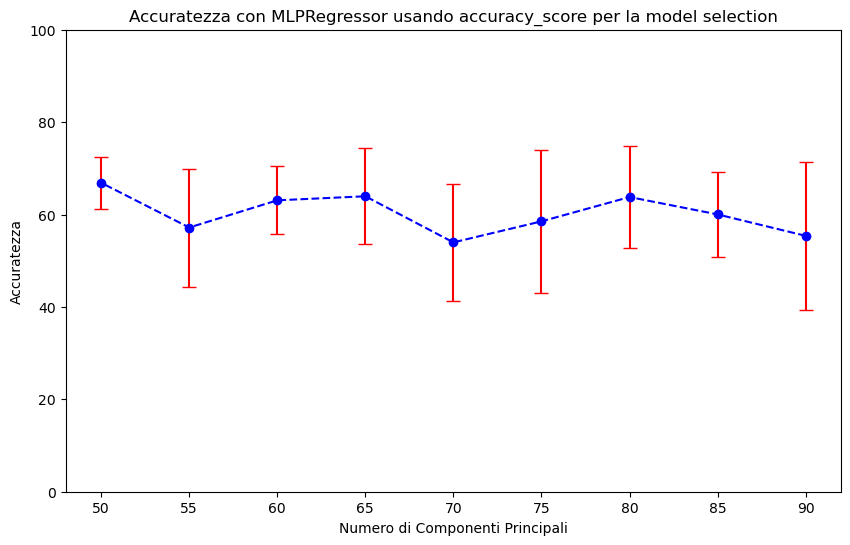

In [19]:
plot_error_bar(scores_df, 0, 8, 'MLPRegressor', 'accuracy_score')

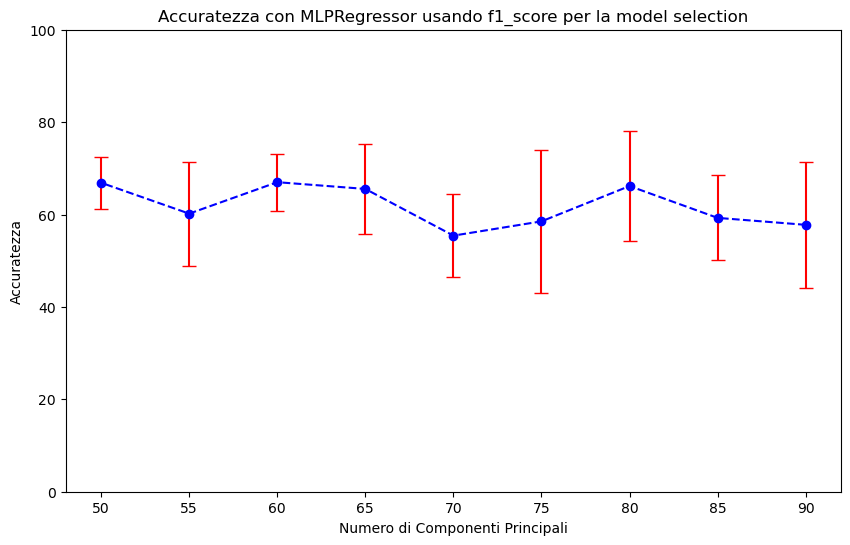

In [20]:
plot_error_bar(scores_df, 9, 17, 'MLPRegressor', 'f1_score')

In [21]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

file_handler = logging.FileHandler('../logs/svm_neural_other_class_nested_cv.log')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger()

logger.handlers = []
logger.addHandler(file_handler)

In [22]:
for n_comp in range (80, 39, -5):
    scores_df = add_record(scores_df, nested_cv_extended(X, random_seed, n_components=n_comp, mod_selection_score=accuracy_score, positive_class=1))

scores_df

,algorythm,best kernel,best gamma,best nu,n_components,best scaler,score used for model selection,method used for model selection,accuracy mean,accuracy std,precision mean,precision std,recall mean,recall std,f1 mean,f1 std,best overall accuracy,class
0,OneClassSVM,rbf,0.001,0.255000,90,MinMaxScaler(),accuracy_score,nested cv,55.388471,16.087458,54.875283,25.564176,44.285714,24.989794,48.359133,24.711430,88.888889,0
1,OneClassSVM,rbf,0.100,0.295833,85,MinMaxScaler(),accuracy_score,nested cv,60.025063,9.257930,66.545558,13.034036,57.142857,19.794866,59.511051,10.893912,68.421053,0
2,OneClassSVM,rbf,0.001,0.336667,80,MinMaxScaler(),accuracy_score,nested cv,63.784461,11.001114,74.115646,16.631018,51.428571,15.518258,59.700153,14.690772,73.684211,0
3,OneClassSVM,rbf,0.100,0.479583,75,MinMaxScaler(),accuracy_score,nested cv,58.521303,15.513562,63.809524,18.294641,54.285714,17.612611,57.726038,17.571019,83.333333,0
4,OneClassSVM,rbf,0.100,0.336667,70,MinMaxScaler(),accuracy_score,nested cv,53.968254,12.718321,57.777778,11.944692,55.714286,17.612611,55.699639,13.640542,77.777778,0
5,OneClassSVM,rbf,0.100,0.234583,65,MinMaxScaler(),accuracy_score,nested cv,63.951546,10.349289,64.032634,8.910834,70.000000,22.038927,65.552956,16.647977,83.333333,0
6,OneClassSVM,rbf,0.001,0.275417,60,MinMaxScaler(),accuracy_score,nested cv,63.074353,7.351950,64.049165,5.605483,71.428571,14.568627,66.984127,8.439716,72.222222,0
7,OneClassSVM,rbf,0.100,0.357083,55,MinMaxScaler(),accuracy_score,nested cv,57.184628,12.770073,58.388992,11.924388,55.714286,25.555063,55.654201,18.728437,83.333333,0
8,OneClassSVM,rbf,0.001,0.479583,50,MinMaxScaler(),accuracy_score,nested cv,66.875522,5.628103,78.356009,11.610786,57.142857,11.605769,64.487900,7.125725,73.684211,0
9,OneClassSVM,rbf,0.001,0.255000,90,MinMaxScaler(),f1_score,nested cv,57.769424,13.703848,61.081458,12.343540,60.000000,21.380899,59.036517,15.687861,88.888889,0


In [23]:
for n_comp in range (80, 39, -5):
    scores_df = add_record(scores_df, nested_cv_extended(X, random_seed, n_components=n_comp, mod_selection_score=f1_score, positive_class=1))

scores_df

,algorythm,best kernel,best gamma,best nu,n_components,best scaler,score used for model selection,method used for model selection,accuracy mean,accuracy std,precision mean,precision std,recall mean,recall std,f1 mean,f1 std,best overall accuracy,class
0,OneClassSVM,rbf,0.001,0.255000,90,MinMaxScaler(),accuracy_score,nested cv,55.388471,16.087458,54.875283,25.564176,44.285714,24.989794,48.359133,24.711430,88.888889,0
1,OneClassSVM,rbf,0.100,0.295833,85,MinMaxScaler(),accuracy_score,nested cv,60.025063,9.257930,66.545558,13.034036,57.142857,19.794866,59.511051,10.893912,68.421053,0
2,OneClassSVM,rbf,0.001,0.336667,80,MinMaxScaler(),accuracy_score,nested cv,63.784461,11.001114,74.115646,16.631018,51.428571,15.518258,59.700153,14.690772,73.684211,0
3,OneClassSVM,rbf,0.100,0.479583,75,MinMaxScaler(),accuracy_score,nested cv,58.521303,15.513562,63.809524,18.294641,54.285714,17.612611,57.726038,17.571019,83.333333,0
4,OneClassSVM,rbf,0.100,0.336667,70,MinMaxScaler(),accuracy_score,nested cv,53.968254,12.718321,57.777778,11.944692,55.714286,17.612611,55.699639,13.640542,77.777778,0
5,OneClassSVM,rbf,0.100,0.234583,65,MinMaxScaler(),accuracy_score,nested cv,63.951546,10.349289,64.032634,8.910834,70.000000,22.038927,65.552956,16.647977,83.333333,0
6,OneClassSVM,rbf,0.001,0.275417,60,MinMaxScaler(),accuracy_score,nested cv,63.074353,7.351950,64.049165,5.605483,71.428571,14.568627,66.984127,8.439716,72.222222,0
7,OneClassSVM,rbf,0.100,0.357083,55,MinMaxScaler(),accuracy_score,nested cv,57.184628,12.770073,58.388992,11.924388,55.714286,25.555063,55.654201,18.728437,83.333333,0
8,OneClassSVM,rbf,0.001,0.479583,50,MinMaxScaler(),accuracy_score,nested cv,66.875522,5.628103,78.356009,11.610786,57.142857,11.605769,64.487900,7.125725,73.684211,0
9,OneClassSVM,rbf,0.001,0.255000,90,MinMaxScaler(),f1_score,nested cv,57.769424,13.703848,61.081458,12.343540,60.000000,21.380899,59.036517,15.687861,88.888889,0


In [15]:
file_path = '../pickles/svm_neural_df.pickle'

with open(file_path, "wb") as file:
    pickle.dump(scores_df, file)